In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from med_seg.data_input import *

from pathlib import Path
import json
import pydicom as dicom
from scipy.ndimage import zoom
from collections import Counter

from matplotlib import animation
from IPython.display import HTML

import gzip
import h5py

/home/vhl_ai/anaconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
PATH = Path('../AnatomyDL/Dataset/')
SAMPLE_DN = 'GAN'

In [4]:
# TRAIN_DN = 'train'
# SAMPLE_DN = 'valid'
# (PATH/TRAIN_DN).mkdir(exist_ok=True)

In [5]:
# files = os.listdir(f'{PATH}/valid/Aortic_Valve/')
# len(files)

In [6]:
# (PATH/'GAN').mkdir(exist_ok=True)
# for i in range(0,len(files)):
#     img =  Image.open(f'{PATH}/valid/Aortic_Valve/{files[i]}')
#     arr = np.array(img)
#     #res = np.resize(arr, (128,128,3))
#     np.save(f'{PATH}/GAN/{files[i]}'[:-4], arr)

In [7]:
files = os.listdir(f'{PATH}/GAN/')
len(files)

5155

In [8]:
img = np.load(f'{PATH}/GAN/{files[2]}')
img.shape

(480, 640, 3)

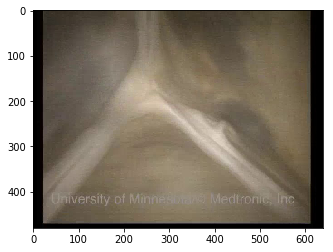

In [9]:
imgplot = plt.imshow(img)
plt.show()

In [10]:
class GANArraysDataset(ArraysDataset):
    def get_x(self, i): return self.x[i]
    def get_y(self, i): return 0

    def get_c(self): return 0
    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.
        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [12]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [13]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [14]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [15]:
bs,sz,nz = 64,64,100

In [16]:
file_names = sorted([i.name for i in list((PATH/'GAN').iterdir())])
x_names = np.array([Path(SAMPLE_DN)/f'{o}' for o in file_names])

In [17]:
np.load(PATH/x_names[0]).shape

(480, 640, 3)

In [18]:
all_imgs = [np.load(PATH/i) for i in x_names]
all_imgs = np.array(all_imgs)[None,...]
all_imgs = np.concatenate(all_imgs, axis=0)

trn_x = all_imgs[:,...]
trn_y = all_imgs[:,...]
val_x = all_imgs[0:1,...]
val_y = all_imgs[0:1,...]
smple = all_imgs[0:500,...]
stats = [[smple.mean()], [smple.std()]]


In [19]:
trn_x.shape, val_x.shape, stats

((5155, 480, 640, 3),
 (1, 480, 640, 3),
 [[113.36116923611111], [52.80365289575435]])

In [20]:
sz = 64
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO)
# tfms[0].tfms = tfms[0].tfms[2:-1]
# tfms[1].tfms = tfms[1].tfms[2:-1]
tfms

([<fastai.transforms.Scale object at 0x7f414bb1fcc0>, <fastai.transforms.NoCrop object at 0x7f414bb1f668>, <fastai.transforms.Normalize object at 0x7f414bb1f3c8>, <fastai.transforms.ChannelOrder object at 0x7f414bb1f908>],
 [<fastai.transforms.Scale object at 0x7f414bb1ffd0>, <fastai.transforms.NoCrop object at 0x7f414bb1f828>, <fastai.transforms.Normalize object at 0x7f414bb1f3c8>, <fastai.transforms.ChannelOrder object at 0x7f414bb1f8d0>])

In [21]:
datasets = ImageData.get_ds(GANArraysDataset, (trn_x, trn_y), (val_y, val_y), tfms=tfms)
#datasets = ImageData.get_ds(MatchedArraysDataset, (trn_all_slices, trn_all_slices_masks), (val_all_slices, val_all_slices_masks),tfms=(None,None))

md = ImageData(PATH, datasets, 64, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [22]:
x,_ = next(iter(md.trn_dl))

In [23]:
dx = denorm(x)[0]
dx.shape, x.shape, np.min(dx), np.max(dx)

((64, 64, 3), torch.Size([64, 3, 64, 64]), 0.0, 230.0)

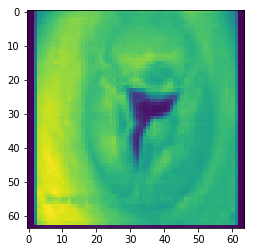

In [24]:
plt.imshow(dx[:,:,0]);
plt.show()

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
frames = []
for i in range(64):
    if (i % 1 ==0):
        im = plt.imshow(denorm(x)[i,:,:,0])
        frames.append([im])
plt.close(fig)

ani = animation.ArtistAnimation(fig,frames,interval=100, blit=True,repeat_delay=1000)
HTML(ani.to_jshtml(default_mode="reflect"))

In [27]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [1080]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

In [30]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True) 
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0]) 
                    real_loss = netD(real) 
                    fake = netG(create_noise(real.size(0))) 
                    fake_loss = netD(V(fake.data)) 
                    netD.zero_grad()
                    lossD = real_loss-fake_loss 
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False) 
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs)))
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
        
        print(f'Epoch {epoch,niter}; Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [31]:
torch.backends.cudnn.benchmark=True

In [32]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 10e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 10e-4)

In [33]:
train(500, False)

100%|██████████| 81/81 [00:02<00:00, 28.97it/s]
Epoch (0, 500); Loss_D [-1.56979]; Loss_G [1.02673]; D_real [-0.7864]; Loss_D_fake [0.78339]
100%|██████████| 81/81 [00:02<00:00, 28.55it/s]
Epoch (1, 500); Loss_D [-0.62082]; Loss_G [0.50745]; D_real [-0.61815]; Loss_D_fake [0.00267]
100%|██████████| 81/81 [00:02<00:00, 33.99it/s]
Epoch (2, 500); Loss_D [-0.28619]; Loss_G [0.04251]; D_real [-0.74819]; Loss_D_fake [-0.46199]
100%|██████████| 81/81 [00:02<00:00, 27.55it/s]
Epoch (3, 500); Loss_D [-1.57394]; Loss_G [0.98554]; D_real [-0.79551]; Loss_D_fake [0.77842]
100%|██████████| 81/81 [00:02<00:00, 33.82it/s]
Epoch (4, 500); Loss_D [-1.51637]; Loss_G [0.83118]; D_real [-0.79441]; Loss_D_fake [0.72196]
100%|██████████| 81/81 [00:02<00:00, 28.22it/s]
Epoch (5, 500); Loss_D [-1.52236]; Loss_G [0.90614]; D_real [-0.78244]; Loss_D_fake [0.73992]
100%|██████████| 81/81 [00:02<00:00, 27.06it/s]
Epoch (6, 500); Loss_D [-1.52036]; Loss_G [0.84581]; D_real [-0.79494]; Loss_D_fake [0.72541]
100%|█

100%|██████████| 81/81 [00:02<00:00, 27.52it/s]]
Epoch (57, 500); Loss_D [-1.23242]; Loss_G [0.20069]; D_real [-0.60336]; Loss_D_fake [0.62906]
100%|██████████| 81/81 [00:02<00:00, 27.72it/s]]
Epoch (58, 500); Loss_D [-0.24841]; Loss_G [0.19405]; D_real [0.20774]; Loss_D_fake [0.45615]
100%|██████████| 81/81 [00:02<00:00, 33.66it/s]]
Epoch (59, 500); Loss_D [-0.76152]; Loss_G [0.72114]; D_real [-0.69521]; Loss_D_fake [0.06631]
100%|██████████| 81/81 [00:02<00:00, 27.87it/s]]
Epoch (60, 500); Loss_D [-0.46459]; Loss_G [-0.01042]; D_real [0.14278]; Loss_D_fake [0.60737]
100%|██████████| 81/81 [00:02<00:00, 27.98it/s]]
Epoch (61, 500); Loss_D [-0.95269]; Loss_G [0.69651]; D_real [-0.67501]; Loss_D_fake [0.27768]
100%|██████████| 81/81 [00:02<00:00, 27.35it/s]]
Epoch (62, 500); Loss_D [-0.70021]; Loss_G [0.77362]; D_real [-0.68614]; Loss_D_fake [0.01407]
100%|██████████| 81/81 [00:02<00:00, 27.65it/s]]
Epoch (63, 500); Loss_D [-1.058]; Loss_G [0.33487]; D_real [-0.52071]; Loss_D_fake [0.53

100%|██████████| 81/81 [00:02<00:00, 33.56it/s]t]
Epoch (114, 500); Loss_D [-0.18883]; Loss_G [0.32277]; D_real [0.39608]; Loss_D_fake [0.58491]
100%|██████████| 81/81 [00:02<00:00, 28.01it/s]t]
Epoch (115, 500); Loss_D [-0.27587]; Loss_G [0.21109]; D_real [0.31443]; Loss_D_fake [0.5903]
100%|██████████| 81/81 [00:02<00:00, 27.62it/s]t]
Epoch (116, 500); Loss_D [-0.62919]; Loss_G [-0.21656]; D_real [-0.06897]; Loss_D_fake [0.56022]
100%|██████████| 81/81 [00:02<00:00, 27.36it/s]t]
Epoch (117, 500); Loss_D [-0.52429]; Loss_G [0.44595]; D_real [-0.37338]; Loss_D_fake [0.15092]
100%|██████████| 81/81 [00:03<00:00, 33.61it/s]t]
Epoch (118, 500); Loss_D [-0.78819]; Loss_G [-0.41253]; D_real [-0.2319]; Loss_D_fake [0.55629]
100%|██████████| 81/81 [00:02<00:00, 27.43it/s]t]
Epoch (119, 500); Loss_D [-0.70434]; Loss_G [0.35715]; D_real [-0.41506]; Loss_D_fake [0.28928]
100%|██████████| 81/81 [00:02<00:00, 30.08it/s]t]
Epoch (120, 500); Loss_D [-0.6141]; Loss_G [-0.36624]; D_real [0.05712]; Los

100%|██████████| 81/81 [00:02<00:00, 27.75it/s]t]
Epoch (226, 500); Loss_D [-0.06207]; Loss_G [-0.08622]; D_real [0.06627]; Loss_D_fake [0.12834]
100%|██████████| 81/81 [00:02<00:00, 28.69it/s]t]
Epoch (227, 500); Loss_D [-0.21669]; Loss_G [0.09182]; D_real [-0.28726]; Loss_D_fake [-0.07057]
100%|██████████| 81/81 [00:02<00:00, 33.56it/s]t]
Epoch (228, 500); Loss_D [-0.16575]; Loss_G [0.05814]; D_real [-0.54103]; Loss_D_fake [-0.37528]
100%|██████████| 81/81 [00:02<00:00, 28.25it/s]t]
Epoch (229, 500); Loss_D [-0.12723]; Loss_G [0.17858]; D_real [0.32001]; Loss_D_fake [0.44724]
100%|██████████| 81/81 [00:02<00:00, 33.50it/s]t]
Epoch (230, 500); Loss_D [-0.3647]; Loss_G [0.37565]; D_real [-0.44555]; Loss_D_fake [-0.08085]
100%|██████████| 81/81 [00:02<00:00, 27.75it/s]t]
Epoch (231, 500); Loss_D [-0.59546]; Loss_G [-0.26681]; D_real [-0.14381]; Loss_D_fake [0.45165]
100%|██████████| 81/81 [00:02<00:00, 27.64it/s]t]
Epoch (232, 500); Loss_D [-0.50558]; Loss_G [0.66562]; D_real [-0.61323]

100%|██████████| 81/81 [00:02<00:00, 27.23it/s]t]
Epoch (339, 500); Loss_D [0.05284]; Loss_G [0.00179]; D_real [0.25406]; Loss_D_fake [0.20121]
100%|██████████| 81/81 [00:02<00:00, 33.63it/s]t]
Epoch (340, 500); Loss_D [-0.01064]; Loss_G [-0.24307]; D_real [-0.46489]; Loss_D_fake [-0.45425]
100%|██████████| 81/81 [00:02<00:00, 28.03it/s]t]
Epoch (341, 500); Loss_D [-0.06083]; Loss_G [-0.38342]; D_real [-0.10807]; Loss_D_fake [-0.04724]
100%|██████████| 81/81 [00:02<00:00, 28.20it/s]t]
Epoch (342, 500); Loss_D [-0.12848]; Loss_G [0.14376]; D_real [-0.34183]; Loss_D_fake [-0.21335]
100%|██████████| 81/81 [00:02<00:00, 33.56it/s]t]
Epoch (343, 500); Loss_D [-0.01776]; Loss_G [-0.01913]; D_real [-0.15668]; Loss_D_fake [-0.13892]
100%|██████████| 81/81 [00:02<00:00, 28.02it/s]t]
Epoch (344, 500); Loss_D [-0.03153]; Loss_G [-0.06209]; D_real [-0.32223]; Loss_D_fake [-0.29071]
100%|██████████| 81/81 [00:02<00:00, 27.74it/s]t]
Epoch (345, 500); Loss_D [-0.00117]; Loss_G [-0.34961]; D_real [-0.

100%|██████████| 81/81 [00:02<00:00, 28.19it/s]t]
Epoch (451, 500); Loss_D [-0.02926]; Loss_G [-0.41461]; D_real [-0.64294]; Loss_D_fake [-0.61368]
100%|██████████| 81/81 [00:02<00:00, 27.52it/s]t]
Epoch (452, 500); Loss_D [-0.1027]; Loss_G [-0.53122]; D_real [0.05359]; Loss_D_fake [0.15628]
100%|██████████| 81/81 [00:02<00:00, 27.80it/s]t]
Epoch (453, 500); Loss_D [0.01945]; Loss_G [0.61377]; D_real [0.61805]; Loss_D_fake [0.5986]
100%|██████████| 81/81 [00:02<00:00, 28.43it/s]t]
Epoch (454, 500); Loss_D [-0.07006]; Loss_G [0.08052]; D_real [-0.13743]; Loss_D_fake [-0.06737]
100%|██████████| 81/81 [00:02<00:00, 28.09it/s]t]
Epoch (455, 500); Loss_D [0.04656]; Loss_G [-0.26201]; D_real [-0.14133]; Loss_D_fake [-0.18789]
100%|██████████| 81/81 [00:02<00:00, 33.56it/s]t]
Epoch (456, 500); Loss_D [-0.07189]; Loss_G [0.12323]; D_real [-0.19342]; Loss_D_fake [-0.12153]
100%|██████████| 81/81 [00:02<00:00, 28.17it/s]t]
Epoch (457, 500); Loss_D [-0.08733]; Loss_G [-0.24432]; D_real [-0.19221]

In [494]:
def gallery(x, nc=1):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [1]:
netD.eval(); netG.eval();

fixed_noise = create_noise(bs)
fake = netG(fixed_noise).data.cpu()
faked = np.clip(denorm(fake),0,255)
faked_cut = faked[0:8,...]

gan_sz=32
plt.figure(figsize=(gan_sz,gan_sz))
gan_imgs = gallery(faked_cut, 8)
plt.imshow(gan_imgs.astype(np.uint8))

NameError: name 'netD' is not defined

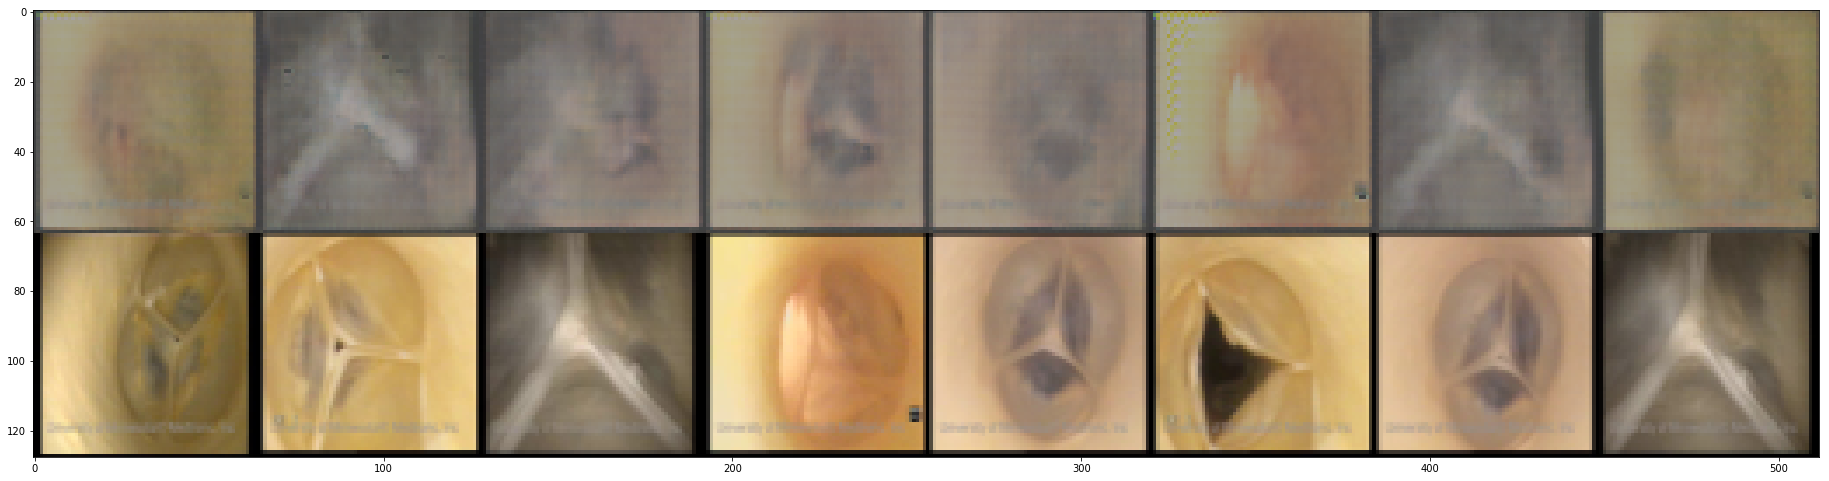

In [1202]:
real = next(iter(md.trn_dl))[0].data.cpu()
reald = np.clip(denorm(real),0,255)
real_cut = reald[0:8,...]

mix = np.concatenate([faked_cut, real_cut], axis=0)

gan_sz=32
plt.figure(figsize=(gan_sz,gan_sz))
real_imgs = gallery(mix, 8)
plt.imshow(real_imgs.astype(np.uint8))

In [1109]:
real_img_path = PATH/'FID'/'gan'
real_img_path

PosixPath('../AnatomyDL/Dataset/FID/gan')

In [1124]:
os.listdir(f'{PATH}/FID/real')

[]

In [1132]:
import imageio

In [1146]:
for i in range(0, len(faked)):
    gan_img = faked[i,...]
    imageio.imwrite(f'{PATH}/FID/gan/gan_img_{i}_1.png', gan_img)

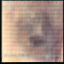

In [1151]:
gan_png = os.listdir(PATH/'FID'/'gan')
Image.open(f'{PATH}/FID/gan/{gan_png[4]}')


In [1189]:
torch.save(netD.state_dict(), 'WGAN_85000_netD.pt')
torch.save(netG.state_dict(), 'WGAN_85000_netG.pt')
torch.save(optimizerD.state_dict(), 'WGAN_85000_optD.pt')
torch.save(optimizerG.state_dict(), 'WGAN_85000_optG.pt')

In [1185]:
netD.train(); netG.train();
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 10e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 10e-4)

In [ ]:
train(10000, False)